In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

"""Change to the data folder"""
train_path = "../new_train/new_train"
val_path = '../new_val_in/new_val_in'

In [2]:
class ArgoverseDataset(Dataset):
    
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self): #len(val_dataset)
        return len(self.pkl_list)
    
    def __getitem__(self, idx): #val_dataset[0]
        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
        if self.transform:
            data = self.transform(data)
        return data

In [3]:
init_dataset = ArgoverseDataset(data_path=train_path) 
val_dataset  = ArgoverseDataset(data_path=val_path) 
print(len(init_dataset), len(val_dataset))

205942 3200


In [4]:
lengths = [int(len(init_dataset)*0.7) + 1, int(len(init_dataset)*0.3)]
#lengths = [int(len(init_dataset)*0.2) + 1, int(len(init_dataset)*0.5), int(len(init_dataset)*0.3)]

print(lengths)
train_dataset, test_dataset = random_split(init_dataset, lengths)
#print(len(small_train_dataset), len(test_dataset), len(val_dataset))

[144160, 61782]


In [5]:
batch_sz = 256
def my_collate(batch): #[scene['p_in'][scene['car_mask'].reshape(-1) == 1]]
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out']]) for scene in batch]
    inp = torch.FloatTensor(inp) #LongTensor
    out = torch.FloatTensor(out) #LongTensor
    return [inp, out]
train_loader = DataLoader(train_dataset, batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=8)

In [6]:
def my_collate(batch): #[scene['p_in'][scene['car_mask'].reshape(-1) == 1]]
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in']]) for scene in batch]
    inp = torch.FloatTensor(inp) #LongTensor
    return inp

val_loader = DataLoader(val_dataset, batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=8)

for i_batch, sample_batch in enumerate(val_loader):
    print(sample_batch.shape)

torch.Size([256, 60, 19, 2])
torch.Size([256, 60, 19, 2])
torch.Size([256, 60, 19, 2])
torch.Size([256, 60, 19, 2])
torch.Size([256, 60, 19, 2])
torch.Size([256, 60, 19, 2])
torch.Size([256, 60, 19, 2])
torch.Size([256, 60, 19, 2])
torch.Size([256, 60, 19, 2])
torch.Size([256, 60, 19, 2])
torch.Size([256, 60, 19, 2])
torch.Size([256, 60, 19, 2])
torch.Size([128, 60, 19, 2])


## LSTM Encoder Decoder

In [126]:
class Encoder_LSTM(nn.Module):
    def __init__(self, input_size = 120, hidden_dim = 1024, dropout = 0.2):
        super(Encoder_LSTM, self).__init__()
        
        self.dropout = nn.Dropout(dropout)
        self.hidden_layer = 2
        self.hidden_dim = hidden_dim
        self.input_size = input_size

        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_dim, 
                            num_layers = self.hidden_layer, dropout = dropout)


    def forward(self, x):
        x, self.hidden = self.lstm(x)
        
        return x, self.hidden
    
    def self_hidden(self, batch_size):
        return (torch.zeros((self.hidden_layer, batch_size, self.hidden_dim)).cuda(),
                torch.zeros((self.hidden_layer, batch_size, self.hidden_dim)).cuda())

In [145]:
class Decoder_LSTM(nn.Module):
    def __init__(self, input_size = 120, hidden_dim = 1024 , dropout = 0.2):
        super(Decoder_LSTM, self).__init__()
        
        self.input_size = input_size
        self.dropout = nn.Dropout(dropout)
        self.hidden_layer = 2
        self.hidden_dim = hidden_dim
        self.input_size = input_size

        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_dim, 
                            num_layers = self.hidden_layer, dropout = dropout)
        
        self.linear = nn.Linear(self.hidden_dim, self.input_size)


    def forward(self, x, encoder_hidden):
        x, self.hidden = self.lstm(x, encoder_hidden)
        out = self.linear(x.squeeze(0))
        
        return out, self.hidden

In [155]:
import time
class seq2seq(nn.Module):
    def __init__(self, input_size = 120, hidden_dim = 1024):
        super(seq2seq, self).__init__()
        
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.dropout = 0.2
        
        self.encoder = Encoder_LSTM(input_size = self.input_size, hidden_dim = self.hidden_dim, dropout = self.dropout).cuda()
        self.decoder = Decoder_LSTM(input_size = self.input_size, hidden_dim = self.hidden_dim, dropout = self.dropout).cuda()
        
    def train(self, train_loader):
        
        batch_sz = 256
        epochs = 40
        learning_rate = 1e-3
        decay = 1e-4
        prediction_size = 60
        teaching_ratio = 0.7
        
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=decay)
        criterion = nn.MSELoss()      
        
        losses = np.zeros(epochs)

        with trange(epochs) as tr:
            for i in tr:
                batch_loss = 0.
                start = time.time()
                print('epoch', i + 1)
                
                for i_batch, (seq, labels) in enumerate(train_loader):
                    
                    seq = seq.permute(0, 2, 1, 3).contiguous() #.view(seq.shape[0], seq.shape[1], -1)
                    seq = seq.view(seq.shape[0], seq.shape[1], -1)
                    seq, labels = seq.cuda(), labels.cuda()

                    outputs = torch.zeros(prediction_size, batch_sz, seq.shape[2])
                    enc_hidden = self.encoder.self_hidden(batch_sz)
                    
                    optimizer.zero_grad()

                    enc_output, enc_hidden = self.encoder(seq)

                    dec_input = seq[:, -19:, :]
                    dec_hidden = enc_hidden

                    # https://github.com/lkulowski/LSTM_encoder_decoder/blob/master/code/lstm_encoder_decoder.py
                    # Using mixed teacher forcing method, other methods are available
        
                    print(dec_input.shape)
                    for t in range(prediction_size):
                        dec_output, dec_hidden = self.decoder(dec_input, dec_hidden)
                        print(dec_output.shape)
                        outputs[:, t] = dec_output

                        if random.random() < teaching_ratio:
                            dec_input = labels[:, t]
                        else:
                            dec_input = dec_output

                    loss = criterion(labels, outputs)
                    batch_loss += loss.item()

                    loss.backward()
                    optimizer.step()

                batch_loss /= batch_size
                losses[i] = batch_loss

                tr.set_postfix(loss = "{:.2f}".format(batch_loss))
                
        return losses

In [156]:
model = seq2seq()
loss = model.train(train_loader)

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 1
torch.Size([256, 19, 120])
torch.Size([256, 19, 120])


  0%|          | 0/40 [00:04<?, ?it/s]


RuntimeError: expand(torch.cuda.FloatTensor{[256, 19, 120]}, size=[60, 120]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

## Base model

In [207]:
class base_model(nn.Module):
    def __init__(self, input_size = 120, dropout = 0.4):
        super().__init__()
        
        self.dropout = nn.Dropout(dropout)
        self.hidden_layer_size = 2
        self.hidden_dim = 2880

        self.lstm = nn.LSTM(input_size, self.hidden_dim, num_layers = self.hidden_layer_size, 
                            batch_first = True, dropout = dropout)

        self.linear = nn.Conv1d(self.hidden_dim, 1200, 1)
        
        self.linear2 = nn.Conv1d(1200, 120, 1)
        
        self.dropout = nn.Dropout(p = dropout)
        


    def forward(self, x):
        x,_ = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.dropout(x)
        x = F.relu(self.linear(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = x.transpose(1, 2)
        
        return x
    
    def forward_test(self, x, steps = 30):
        fut = []
        h = torch.zeros((self.hidden_layer_size, len(x), self.hidden_dim)).cuda()
        c = torch.zeros((self.hidden_layer_size, len(x), self.hidden_dim)).cuda()
        for num_iter in range(steps):
            x, (h, c) = self.lstm(x, (h, c))
            x = x[:, -1:]
            x = x.transpose(1, 2)
            x = self.dropout(x)
            x = F.relu(self.linear(x))
            x = self.dropout(x)
            x = self.linear2(x)
            x = x.transpose(1, 2)
            fut.append(x)
        fut = torch.cat(fut, 1)
        return fut

In [208]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = base_model().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-4)
criterion = nn.MSELoss()
print(model)

cuda
base_model(
  (dropout): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(120, 2880, num_layers=2, batch_first=True, dropout=0.4)
  (linear): Conv1d(2880, 1200, kernel_size=(1,), stride=(1,))
  (linear2): Conv1d(1200, 120, kernel_size=(1,), stride=(1,))
)


In [209]:
epochs = 40
loss_ema = -1
loss_ema_test = -1

loss_list = []


for i in range(epochs):
    start = time.time()
    print('epoch', i + 1)
    for i_batch, sample_batch in enumerate(train_loader):
        losses = 0
        model.train()
        seq, labels = sample_batch
        seq = seq.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        full = torch.cat([seq, labels], 2).transpose(1, 2).reshape((-1, 49, 120)).float()
        
        y_pred = model(full[:, :-1])[:, -30:]
        y_pred = y_pred.reshape((-1, 30, 60, 2)).transpose(1, 2)
        
        loss = criterion(labels, y_pred) #(torch.mean(y_pred - labels) ** 2)** 0.5
        
        loss.backward()
        optimizer.step()
        
        if loss_ema < 0:
            loss_ema = loss
        loss_ema = loss_ema*0.99 + loss * 0.01
        losses += loss.item()
        
        with torch.no_grad():
            y_pred_test = model.forward_test(seq.transpose(1,2).reshape(-1, 19, 120))
            y_pred_test = y_pred_test.reshape((-1, 30, 60, 2)).transpose(1, 2)
            loss_test= criterion(y_pred_test, labels) #(torch.mean(y_pred_test - labels) ** 2)** 0.5
            if loss_ema_test < 0:
                loss_ema_test = loss_test
            loss_ema_test = loss_ema_test*0.99 + loss_test * 0.01
        
        if i_batch % 100 == 0:
            print("Full loss", i + 1, i_batch, loss_ema.item(), loss.item())
            
            print("Test loss", i + 1, i_batch, loss_ema_test.item(), loss_test.item())
            
    if i % 2 == 0:
        total_val_loss = 0
        model.eval()
        for i_batch, sample_batch in enumerate(test_loader):
            seq, labels = sample_batch
            seq = seq.cuda()
            labels = labels.cuda()
            with torch.no_grad():
                y_pred_test = model.forward_test(seq.transpose(1,2).reshape(-1, 19, 120))
                y_pred_test = y_pred_test.reshape((-1, 30, 60, 2)).transpose(1, 2)
                loss_val= criterion(y_pred_test, labels) #(torch.mean(y_pred_test - labels) ** 2)** 0.5
            total_val_loss += loss_val
        batch_val_loss = total_val_loss / len(test_loader)
        print("Batch val loss: {:.2f}".format(batch_val_loss))
            
    batch_loss = losses / len(train_loader)
    print("Batch Loss: {:.2f}".format(batch_loss))
    loss_list.append(batch_loss)
    end = time.time()
    print("This epoch took {:.2f} seconds".format(end - start))

epoch 1
Full loss 1 0 678526.8125 678526.8125
Test loss 1 0 678371.625 678371.625
Full loss 1 100 464275.53125 258485.453125
Test loss 1 100 462708.53125 257435.09375
Full loss 1 200 284976.90625 108906.0625
Test loss 1 200 283946.125 107885.609375
Full loss 1 300 176137.078125 97426.9921875
Test loss 1 300 176090.859375 99436.171875
Full loss 1 400 124141.765625 81083.0390625
Test loss 1 400 124808.9296875 83142.6875
Full loss 1 500 96712.75 78902.4609375
Test loss 1 500 97858.75 81420.0390625
Batch val loss: 63965.72
Batch Loss: 104.13
This epoch took 719.27 seconds
epoch 2
Full loss 2 0 85143.640625 74814.3515625
Test loss 2 0 86416.546875 77901.3984375
Full loss 2 100 74260.9609375 66683.2578125
Test loss 2 100 75612.9609375 59095.72265625
Full loss 2 200 67377.890625 68435.4453125
Test loss 2 200 69062.65625 61748.8046875
Full loss 2 300 62511.3828125 52657.078125
Test loss 2 300 64371.4609375 55813.6875
Full loss 2 400 56966.296875 48135.34375
Test loss 2 400 58850.14453125 50077

KeyboardInterrupt: 

KeyboardInterrupt: 

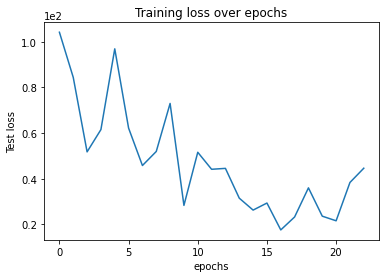

In [211]:
plt.plot(loss_list)
plt.ylabel("Test loss")
plt.xlabel("epochs")
plt.ticklabel_format(axis = "y", style = "sci", scilimits=(0,0))
plt.title("Training loss over epochs")
plt.savefig("loss.png", dpi = 200)

In [25]:
torch.save(model.state_dict(), "trial5.pt")

In [ ]:
model.load_state_dict(torch.load("trial2.pt"))

In [218]:
output_array = np.empty([3200, 60], dtype = "float")
model.eval()

with torch.no_grad():
    for j in range(len(val_dataset)):
        current_scene = val_dataset[j]
        current_scene_id = int(current_scene["scene_idx"])
        target_veh = np.where(current_scene["track_id"][:, 0 , 0] == current_scene["agent_id"])[0]
        input_seq = torch.FloatTensor(numpy.dstack([current_scene['p_in'], current_scene['v_in']])).cuda()
        y_pred_output = model.forward_test(input_seq.transpose(1,2).reshape(-1, 19, 120))
        y_pred_output = y_pred_output.reshape((-1, 30, 60, 2)).transpose(1, 2)
        #print(target_veh)
        #print(y_pred_output[0, 3, :, :].cpu().detach().numpy().flatten())
        output_veh = y_pred_output[0, target_veh, :, :].cpu().detach().numpy().flatten()
        #print(output_veh)
        output_array[j] = output_veh

In [158]:
output_array = np.empty([3200, 60], dtype = "float")
model.eval()

with torch.no_grad():
    for i_batch, sample_batch in enumerate(val_loader):
        sample_batch = sample_batch.cuda()
        output = model.forward_test(sample_batch.transpose(1,2).reshape(-1, 19, 240))
        y_pred_output = y_pred_output.reshape((-1, 30, 60, 4)).transpose(1, 2)
        print(y_pred_output.shape)
        print(y_pred_output.cpu().detach()[:, :, 0, :])
        break

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f22a8fba5f0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f22a8fba5f0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

torch.Size([1, 60, 30, 4])
tensor([[[ 1.8913e+03,  1.2827e+03,  4.3181e-01,  8.2107e-03],
         [ 2.0447e+03,  1.2594e+03,  4.9185e-01,  2.1091e-01],
         [ 2.1346e+03,  1.2548e+03,  5.2664e-01,  2.8830e-01],
         [ 2.1786e+03,  1.2564e+03,  5.4430e-01,  3.1080e-01],
         [ 2.2039e+03,  1.2589e+03,  5.5566e-01,  3.2205e-01],
         [ 2.2230e+03,  1.2615e+03,  5.6504e-01,  3.3027e-01],
         [ 2.2392e+03,  1.2639e+03,  5.7308e-01,  3.3696e-01],
         [ 2.2536e+03,  1.2659e+03,  5.8020e-01,  3.4220e-01],
         [ 2.2701e+03,  1.2678e+03,  5.8842e-01,  3.4595e-01],
         [ 2.2989e+03,  1.2700e+03,  6.0445e-01,  3.4879e-01],
         [ 2.3356e+03,  1.2733e+03,  6.2419e-01,  3.5299e-01],
         [ 2.3658e+03,  1.2772e+03,  6.3869e-01,  3.5769e-01],
         [ 2.4001e+03,  1.2788e+03,  6.6241e-01,  3.7296e-01],
         [ 2.4486e+03,  1.2797e+03,  6.9452e-01,  3.9812e-01],
         [ 2.4773e+03,  1.2791e+03,  7.0355e-01,  4.1517e-01],
         [ 2.4814e+03,  1.27

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f22a8fba5f0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f22a8fba5f0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multipr

In [182]:
ID_array = []
for j in range(len(val_dataset)):
    current_scene = val_dataset[j]
    current_scene_id = int(current_scene["scene_idx"])  
    ID_array.append(current_scene_id)
    
first_row = numpy.array(["ID"])
for i in range(1, 61):
    first_row = np.append(first_row, "v" + str(i))
output_pd = pd.DataFrame(data = output_array, index = ID_array)
output_pd = output_pd.reset_index()
output_pd.columns = first_row

In [183]:
output_pd.head()

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,2035.125854,2712.453613,1711.908691,2476.324219,1346.075684,2434.213379,1184.438354,2302.698242,1018.390076,...,821.567810,2220.396240,822.353821,2220.786377,822.761292,2220.801758,822.586731,2220.362793,822.430115,2219.978271
1,10015,1977.782715,2776.608154,1679.162354,2551.137207,1343.995972,2500.806885,1182.248291,2350.958008,1029.140503,...,737.996521,2330.256592,738.211243,2330.746338,738.425476,2331.235352,738.646729,2331.718262,738.911133,2332.182129
2,10019,2161.729736,2870.184082,1847.937012,2627.224854,1451.998901,2575.147705,1292.328857,2434.724121,1143.206299,...,859.488770,2399.432129,859.717590,2399.860107,859.943359,2400.284912,860.164246,2400.711914,860.380859,2401.126221
3,10028,2210.946289,2628.141602,2042.605713,2461.962891,1681.505371,2291.802002,1436.556274,2196.534424,1253.301514,...,1045.287842,2315.906738,1045.234009,2316.316895,1044.515381,2316.976074,1043.471313,2317.687012,1042.884766,2318.061035
4,1003,1823.865845,2554.524414,1542.870850,2350.400879,1227.935547,2269.351318,1070.217529,2091.079834,946.335083,...,696.935181,2087.850342,697.296814,2088.475830,697.648132,2089.078125,697.988403,2089.661621,698.319092,2090.225586


In [185]:
np.mean(output_pd["v1"])

1806.1553078021109

In [35]:
output_pd.to_csv("submission_523.csv", index = False)